<center> 
<h2><b> Adnan Rashid </b></h2>
    <nav>
        <h3>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
        <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
        <a href="https://adnan.study"> Website </a> |
        <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
        <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
        </h3>
    </nav>
</center>

<h1 style="background:black"><code style="background:black;color:white"><center>Exposing a Service</center></code></h1>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center> We will review how to configure a Service, Deployment or Pod to be exposed outside our cluster. We will also review the different ways to do so.

</center>
</font>
</div>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/21.jpg" width="50%" height="50%" border=5/></center>

* [Creating The Service](#service_create)
* [Accessing The Service](#service_access)
* [DNS](#serivce_dns)
* [Exposing the Service](#service_exposingservice)
* [Ingress](#service_ingress)
* [Ingress Controller](#service_ingresscontroller)

* Explanation of Kubernetes Services 

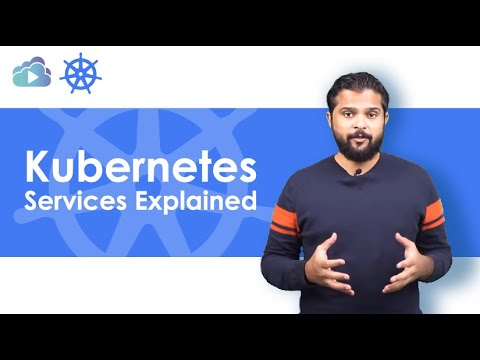

In [139]:
from IPython.display import YouTubeVideo
YouTubeVideo('5lzUpDtmWgM')

<blockquote> Before going into Kubernetes approach to networking, worthwhile understanding normal way networking works with Docker 

* Docker uses <b>host-private networking</b>, containers can talk to other containers only if they are on the same machine 

In order for docker containers to communicate across nodes, there must be allocated ports on the machines own IP address, which are then forwarded or proxies to the containers. This obviously means that containers must either coordinate which ports they use very carefully or ports must be allocated dynamically 

Coordinating ports across multiple developers is very difficult to do at scale and exposes users to cluster-level issues outside of their control. Kubernetes assumes that pods can communicate with other pods, regardless of which host they land on

* We give every pod its own <b>cluster-private-IP</b> address so you do not need to explicitly create links between pods or map container ports to host ports. 

This means that containers within a Pod can all reach each other's ports on localhost, and all pods in a cluster can see each other without NAT 

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

<br>

#### Important 

This lab will not work without recreating the cluster. Something is not cleaned up correctly from previous lab however i have not had a chance to troubleshoot yet. 

#### <br><br>Exposing pods to the cluster 

* Create the namespace 

In [ ]:
!kubectl create ns my-nginx

* Create the nginx deployment with 2 replicas 

In [ ]:
!kubectl -n my-nginx apply -f services/run-my-nginx.yaml 

In [ ]:
!kubectl -n my-nginx get pods -o wide

* Check your pods IP's 

In [ ]:
!kubectl -n my-nginx get pods -o yaml | grep 'podIP:'

## <br><br>Creating a Service  <a class="anchor" id="service_create"></a>

<blockquote>So we have pods running nginx in a flat, cluster wide, address space. In theory, you could talk to these pods directly, but what if a node dies? The pod dies with it, and the deployment will create a new one, with different IPs. This is the problem a services solves 

* A Kubernetes Service is an abstraction which defines a logical set of Pods running somewhere in your cluster, that all provide the same functionality

When created, each Service is assigned a unique IP address (also called clusterIP). This address is tied to the lifespan of the Service, and will not change while the Service is alive. Pods can be configured to talk to the Service, and know that communication to the Service will be automatically load-balanced out to some pod that is a member of the Service 

* Create a service for the 2 nginx replicas with kubectl expose 

In [ ]:
!kubectl -n my-nginx expose deployment/my-nginx

This specification will create a service which targets TCP port 80 on any Pod with the run: my-nginx label and exposes it on an abstracted service port 

* <b>targetPort:</b> is the port the container accepts traffic on
* <b>port:</b> is the abstracted service port, which can be any port other pods use to access the service 

View Service API object to see the list of supported fields in service definition 

* Check your service 

In [ ]:
!kubectl -n my-nginx get svc my-nginx

<br> Service is backed by a group of pods and these pods are exposed through endpoints 

* Service's selector will be evaluated continously and the results will be POSTed to an Endpoints object also named my-nginx
* When a pod dies, it is automatically removed from the endpoints, and new Pods matching the Service's selector will automatically get added to the endpoints

Check the endpoints, and note that the IPs are the same as the Pods created in the first step 

In [ ]:
!kubectl -n my-nginx describe svc my-nginx

<br>The Service IP is completely virtual, it never hits the wire

* Create a variable set with the my-nginx service IP 

In [ ]:
!kubectl -n my-nginx get svc my-nginx -ojsonpath='{.spec.clusterIP}'

* Add the IP address to MyClusterIP below

In [ ]:
%env MyClusterIP=10.100.225.127

<br>Creating a new deployment called <i>load-generator</i> (with the MyClusterIP variable also set inside the container) and get an interactive shell on a pod + container

* Create a new deployment and allocate a TTY for the container in the pod in terminal

<p style="background:black">
<code style="background:black;color:white">> kubectl -n my-nginx run -i --tty load-generator --env="MyClusterIP=${MyClusterIP}" --image=busybox /bin/sh
</code>
</p>

* Connect to the nginx welcome page using the Cluster IP

<p style="background:black">
<code style="background:black;color:white">> wget -q -O - ${MyClusterIP} | grep '<title>'
</code>
</p>

* Exit the container 

<p style="background:black">
<code style="background:black;color:white">> exit
</code>
</p>

## <br><br>Accessing The Service  <a class="anchor" id="service_access"></a>

Kubernetes supports 2 primary modes of finding a Service: environment variables and DNS 

The former works out of the box while the latter requires the CoreDNS cluster add-on (automatically installed when creating the EKS cluster) 

<u>Environment Variables</u>

* When a pod runs on a Node, the <b>kubelet</b> adds a set of environment variables for each active Service. This introduces an ordering problem

To see why, inspect the environment of your running nginx pods.

In [ ]:
!kubectl -n my-nginx get pods -o wide

* Now let's inspect the environment of one of your running nginx pods

In [ ]:
!kubectl -n my-nginx get pods -o jsonpath='{.items[0].metadata.name}'

In [ ]:
!kubectl -n my-nginx exec load-generator -- printenv | grep SERVICE

Another disadvantage of doing this is that the scheduler might put both Pods on the same machine, which will take your entire Service down if it dies

* We can do this the right way by killing the 2 pods and waiting for the deployment to recreate them. This time around the Service exists before the replicas. This will give you scheduler-level Service spreading to your Pods (provided all yoru nodes have equal capacity), as well as the right environment variables: 

In [ ]:
!kubectl -n my-nginx rollout restart deployment my-nginx

In [ ]:
!kubectl -n my-nginx get pods -o wide

* The pods should have different names as they are destroyed and recreated

In [ ]:
!kubectl -n my-nginx get pods  -o jsonpath='{.items[0].metadata.name}'

* Set mypod from the output above

In [ ]:
%env mypod=load-generator

In [ ]:
!kubectl -n my-nginx exec ${mypod} -- printenv | grep SERVICE

In [ ]:
%env KUBERNETES_SERVICE_PORT=443
%env MY_NGINX_SERVICE_PORT=80
%env KUBERNETES_SERVICE_HOST=10.100.0.1
%env KUBERNETES_SERVICE_PORT_HTTPS=443

* Change the following to be like output

In [ ]:
%env MY_NGINX_SERVICE_HOST=10.100.225.127

#### <br><br>DNS 

* Kubernetes offers a DNS cluster add-on Service that automatically assigns dns names to other Services. You can check if its running on your cluster 
* To check if your cluster is already running CoreDNS, run the following

In [ ]:
!kubectl get pod -n kube-system -l k8s-app=kube-dns

* Run the the following in terminal 

<p style="background:black">
<code style="background:black;color:white">> kubectl -n my-nginx run curl --image=radial/busyboxplus:curl -i --tty </code> </p>      

<p style="background:black">
    <code style="background:black;color:white">> nslookup my-nginx</code>
</p>

<p style="background:black">
    <code style="background:black;color:white">> exit</code>
</p>

## <br><br>Exposing the Service  <a class="anchor" id="service_exposingservice"></a>

Some parts of your applications you may want to expose a Service onto an external IP address 

* Kubernetes supports two way sof doing this
    * NodePort 
    * LoadBalancer

In [ ]:
!kubectl -n my-nginx get svc my-nginx

* Currently the service does not have an external ip, so lets patch the Service to use a cloud load balancer, by updating the type of the my-nginx service from <b>ClusterIP</b> to <b>LoadBalancer</b>

In [ ]:
!kubectl -n my-nginx patch svc my-nginx -p '{"spec": {"type": "LoadBalancer"}}'

* We can check for the changes

In [ ]:
!kubectl -n my-nginx get svc my-nginx

* It can take a couple of minutes to become available in DNS

In [ ]:
!kubectl -n my-nginx describe service my-nginx | grep Ingress

In [ ]:
!curl a24b1542c379546ff9f466c6e2b598d5-1490478626.eu-west-1.elb.amazonaws.com

## <br><br>Ingress  <a class="anchor" id="service_ingress"></a>

Ingress was added in Kubernetes v1.1 and exposes HTTP and HTTPS routes from outside the cluster to services within the cluster. 

Traffic routing is controlled by rules defined on the ingress resource 

<p style="background:black">
<code style="background:black;color:white">
    internet
       |
  [ Ingress ]
  --|-----|--
  [ Services ]<br>
</code>
</p>



<blockquote>Ingress can be configured to give services externally-reachable URLs, load balance traffic, terminal SSL, and offer name based virtual hosting. 

* An ingress controller is responsible for fulfilling the ingress, usually with a load balancer, though it may be also configure your edge router or additional frontends to help handle the traffic. 
* An ingress does not expose arbitrary ports or protocols. Exposing services other than HTTP and HTTPS to the internet typically uses a service of type NodePort or LoadBalancer 
* You must have an ingress controller to satisfy an ingress. Only creating an Ingress resource has no effect. 

You may need to deploy an Ingress controller such as AWS ALB Ingress Controller. You can choose from a number of Ingress Controllers

Ideally, all ingress controllers should fit the reference specfication. In reality, the various ingress controllers operate slightly differently. 

### The Ingress Resource

A minimal ingress resource example 

<blockquote>As with all other Kubernetes resources, an ingress needs 
    * apiVersion
    * kind
    * metadata 

* The name of an Ingress object must be valid DNS subdomain name. 

Ingress frequently uses annotations to configure some options depending on the ingress controller, an example of which is the rewrite-target annotation. Different ingress controller support different annotations 

* The ingress spec has all the information needed to configure a load balancer or proxy server. Most importantly it contains a list of rules matched against all incoming requests. 

Ingress resource only supports rules for directing HTTP traffic. 

#### <br><br>Ingress rules 

<blockquote>Each http rule contains the following information 

* An optional host 
    * In this example no host is specified so the rule applies to all inbound HTTP traffic through the IP address specified. 
    * If a host is provided (i.e. foo.bar.com), the rules apply to that host <br><br>
* A list of paths (for example, <b>/testpath</b>)
    * each of which has an associated backend defined with a <b>serviceName</b> and <b>servicePort</b>. 
    * Both the host and path must match the content of an incoming request before the load balancer will direct traffic to the referenced service <br><br> 
* A backend
    * combination of service and port names as described in the Services doc (https://kubernetes.io/docs/concepts/services-networking/service/) 
    * HTTP and HTTPS requests to the ingress matching the host and path of the rule will be sent to the listed backend
    
A default backend is often configured in an Ingress controller that will service any requests that do not match a path in the spec 

#### <br><br> Default Backend 

* An ingress with no rules sends all traffic to a single default backend. 
* The default backend is typically a configuraiton option of the Ingress Controller and is not specified in your ingress resources. 
* If none of the hosts or paths match the HTTP request in the Ingress objects, the traffic is routed to your default backend. 

## <br><br>Ingress Controller  <a class="anchor" id="service_ingresscontroller"></a>


In order for ingress resource to work, the cluster must have an ingress controller running 

Unlike other types of controllers which run as part of the <b>kube-controller-manager</b> binary, Ingress controllers are not started automatically with a cluster

#### <br><br>AWS ALB Ingress Controller

* AWS ALB is a popular AWS service that load balances incoming traffic at the application layer (layer 7) across multiple targets such as EC2 in multiple AZ's 
* ALB supports multiple features including host or path based routing, TLS termination, WebSockets, HTTP/2, AWS WAF, Integrated access logs and health checks

* The open source ALB Ingress controller triggers the creation of an ALB and the necessary supporting AWS resources whenever kubernetes user declares an ingress source in the cluste r
* The Ingress resource users the ALB to route HTTP(S) traffic to different endpoints within the cluster
* The AWS ALB ingress controller works on any Kubernetes cluster including EKS 

#### <br><br>Deploy AWS ALB Ingress Controller 

* Create an IAM OIDC provider and associate it with your cluster

In [ ]:
!eksctl utils associate-iam-oidc-provider --cluster=eksworkshop-eksctl --approve

* Deploy the relevant RBAC roles and role bindings as required by the AWS ALB ingress controller

In [ ]:
!kubectl apply -f alb/rbac-role.yaml

* Create an IAM policy named 'ALBIngressControllerIAMPolicy' to allow the ALB ingress controller to make AWS API calls on your behalf and save the Policy.Arn into a new variable called PolicyARN

In [ ]:
!aws iam create-policy --policy-name ALBIngressControllerIAMPolicy --policy-document file://alb/iam-policy.json

* Get the policy ARN

In [ ]:
!aws iam list-policies --query 'Policies[?PolicyName==`ALBIngressControllerIAMPolicy`].Arn' --output text

* Create a variable with the ARN

In [ ]:
%env PolicyARN=arn:aws:iam::133150622354:policy/ALBIngressControllerIAMPolicy

* Create a kubernetes service account and an IAM role (for the pod running the AWS ALB Ingress controller)

In [ ]:
%%bash

eksctl create iamserviceaccount \
        --cluster=eksworkshop-eksctl \
        --namespace=kube-system \
        --name=alb-ingress-controller \
        --attach-policy-arn=$PolicyARN \
        --override-existing-serviceaccounts \
        --approve

* Deploy the AWS ALB Ingress Controller

In [ ]:
!kubectl apply -f alb/alb-ingress-controller.yaml

* You must have the following on your subnets

    * Key: kubernetes.io/role/elb value: 1
    * Key: kubernetes.io/cluster/eksworkshop-eksctl value:shared
    
* Verify the deployment was successful and the controller started
* If you have other subnets with the same EKS cluster name tagged, it will be picked up and could error
* If you get any issues at this point, you can configure alb/alb-ingress-controller.yaml 

In [ ]:
!kubectl logs -n kube-system $(kubectl get po -n kube-system | egrep -o alb-ingress[a-zA-Z0-9-]+)

#### <br><br>Deploy Sample Application 

* Deploying a sample '2048 game' into our kubernetes cluster and use the Ingress resource to expose it to traffic 

In [ ]:
!kubectl apply -f alb/2048/namespace.yaml
!kubectl apply -f alb/2048/deployment.yaml
!kubectl apply -f alb/2048/service.yaml

* Deploy an ingress resource for the 2048 game 

In [ ]:
!kubectl apply -f alb/2048/ingress.yaml

* Verify that the ingress resource is enabled

In [ ]:
!kubectl get ingress/2048-ingress -n 2048-game

* Wait a few minutes for the application to be ready and you should be able to play the game

<br><br><center><img src="https://www.eksworkshop.com/images/fargate/Browser.png" width="20%" height="20%"/>

## <br><br>Clean Up

In [ ]:
!kubectl delete -f services/run-my-nginx.yaml
!kubectl delete ns my-nginx

In [ ]:
!kubectl delete -f alb/2048/deployment.yaml
!kubectl delete -f alb/2048/service.yaml
!kubectl delete -f alb/2048/ingress.yaml
!kubectl delete -f alb/2048/namespace.yaml
!kubectl delete -f alb/rbac-role.yaml

In [ ]:
!kubectl delete -f alb/alb-ingress-controller.yaml 

In [ ]:
%%bash 

eksctl delete iamserviceaccount \
    --cluster eksworkshop-eksctl \
    --name alb-ingress-controller \
    --namespace kube-system \
    --wait

aws iam delete-policy --policy-arn $PolicyARN